# Support vector machine (SVM)

## 1. Setup project

### 1.1. Environment setup

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

%load_ext dotenv
%dotenv

### 1.2. Build train data

In [2]:
from sailor import SailorDataEngineer, RouteGenConfig

_config = RouteGenConfig(
  api_key=os.getenv("AI_API_KEY"),
  model=os.getenv("AI_MODEL"),
  base_url=os.getenv("AI_MODEL_URL"),
  cache_dir="../build/cache")
_engineer = SailorDataEngineer(_config)

_route_context = "flight agency"
routes_context = await _engineer.generate_data(route_context=_route_context, cache_key="train_flight_agency")

### 1.3. Train test split

In [3]:
from sailor import NavigationContext
from sklearn.model_selection import train_test_split

_train_sessions, _test_sessions = train_test_split(routes_context.sessions, test_size=0.2)

train_context = NavigationContext(routes=routes_context.routes, sessions=_train_sessions)

## 2. Setup model 

In [4]:
import numpy as np
from sailor import RouteVectorizer
from sklearn.svm import LinearSVC

vectorizer = RouteVectorizer()
route_vectors, labels =  vectorizer.fit(train_context)

model = LinearSVC(class_weight="balanced", max_iter=2000)
model.fit(route_vectors, labels)

def recommend_route(query: str, top_n=3):
    query_vec = vectorizer.transform(query)
    scores = model.decision_function(query_vec)[0]
    scores = 1 / (1 + np.exp(-scores))
    sorted_indices = np.argsort(scores)[::-1][:top_n]

    return [(vectorizer.inverse_transform(i), scores[i]) for i in sorted_indices]


## 3. Validate vectorizer 

### 3.1. Test vectorizer

In [5]:
import time

def _test_query(query):
    start_time = time.time()
    results = recommend_route(query)
    latency = (time.time() - start_time)*1000
    print(f"Results ({latency:.2f}ms):")

    for route, score in results:
        print(f"- {route.id} | {route.path} (score: {score:.3f})")

for session in _test_sessions:
    for route in routes_context.routes:
        if route.id == session.route_id:
            break

    query = session.intention.context
    print(f"Query: '{query}'; Expected route: {route.id} | {route.path};")
    _test_query(query)

Query: 'User searching for information about pet travel policy'; Expected route: route-6 | /flights/faq;
Results (0.71ms):
- route-6 | /flights/faq (score: 0.396)
- route-10 | /flights/privacy (score: 0.380)
- route-9 | /flights/terms (score: 0.332)
Query: 'User searching for information about baggage allowance'; Expected route: route-9 | /flights/terms;
Results (0.41ms):
- route-6 | /flights/faq (score: 0.457)
- route-9 | /flights/terms (score: 0.334)
- route-10 | /flights/privacy (score: 0.327)
Query: 'User clicked on 'View Booking History' link'; Expected route: route-7 | /flights/profile;
Results (0.37ms):
- route-5 | /flights/refund (score: 0.366)
- route-7 | /flights/profile (score: 0.365)
- route-2 | /flights/manage (score: 0.355)
Query: 'User checking the status of flight DL789'; Expected route: route-4 | /flights/status;
Results (0.35ms):
- route-4 | /flights/status (score: 0.579)
- route-5 | /flights/refund (score: 0.307)
- route-3 | /flights/deals (score: 0.301)
Query: 'User

### 3.2. Analyze size

In [6]:
print("Vocabulary size:", len(vectorizer._vectorizer.vocabulary_))
print("Vector size:", sys.getsizeof(vectorizer.route_vectors))


Vocabulary size: 95
Vector size: 48


### 3.2. Analyze route similarity

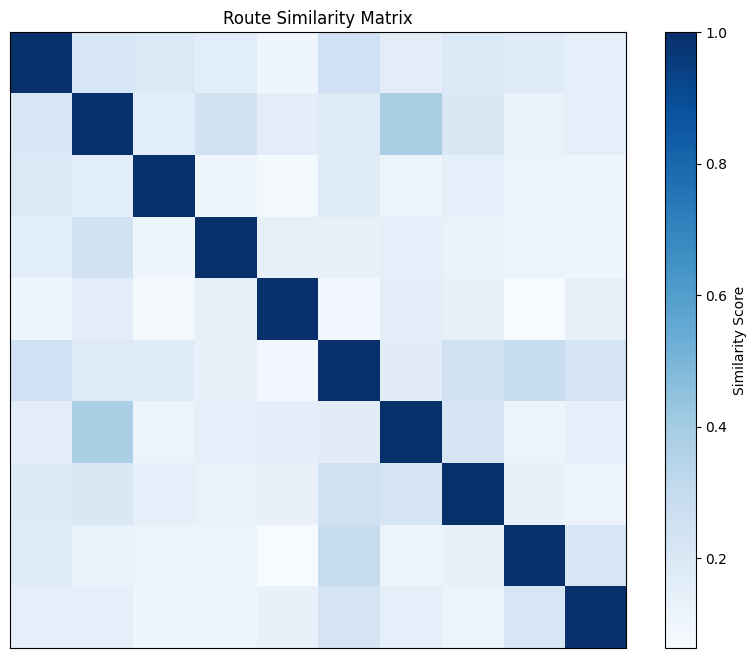

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(vectorizer.route_vectors)
plt.figure(figsize=(10, 8))
plt.imshow(similarity_matrix, cmap="Blues")
plt.colorbar(label="Similarity Score")
plt.title("Route Similarity Matrix")

_test_routes = [r.path for r in routes_context.routes if r in _test_sessions]

plt.xticks(ticks=range(len(_test_routes)), labels=_test_routes, rotation=90)
plt.yticks(ticks=range(len(_test_routes)), labels=_test_routes)

plt.show()